In [17]:
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
from scipy.optimize import minimize
from datetime import datetime
from numpy.random import default_rng
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
data = pd.read_csv('./multualfund_2019_2023.csv')
data.head()

# Convert the date column to datetime format and sort the data
data['date'] = pd.to_datetime(data['date'])
data.sort_values(by=['Name', 'date'], inplace=True)

# Calculate daily returns for each mutual fund
data['daily_return'] = data.groupby('Name')['Price'].pct_change()

# Display the first few rows with daily returns
data.head()


,date,Name,Price,daily_return
2012,2019-11-01,APDYX,12.459257,NaN
2013,2019-11-04,APDYX,12.582095,0.009859
2014,2019-11-05,APDYX,12.546998,-0.002789
2015,2019-11-06,APDYX,12.529449,-0.001399
2016,2019-11-07,APDYX,12.573320,0.003501


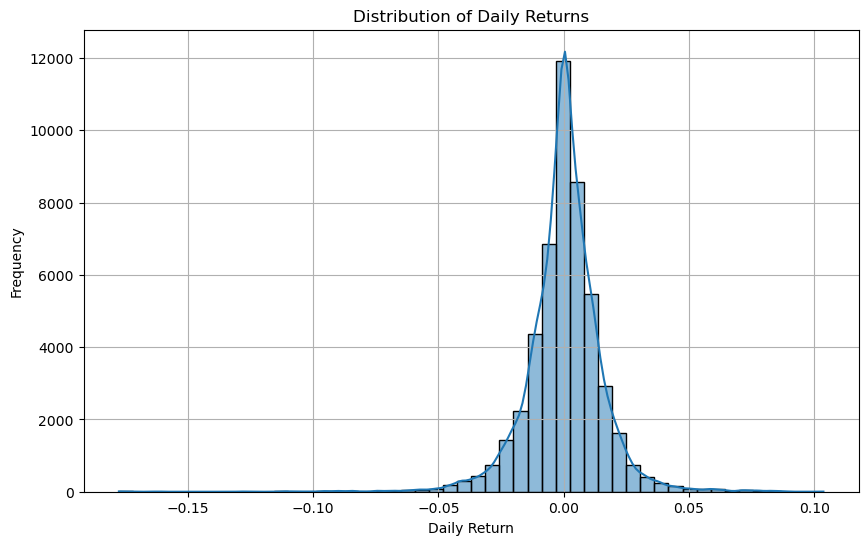

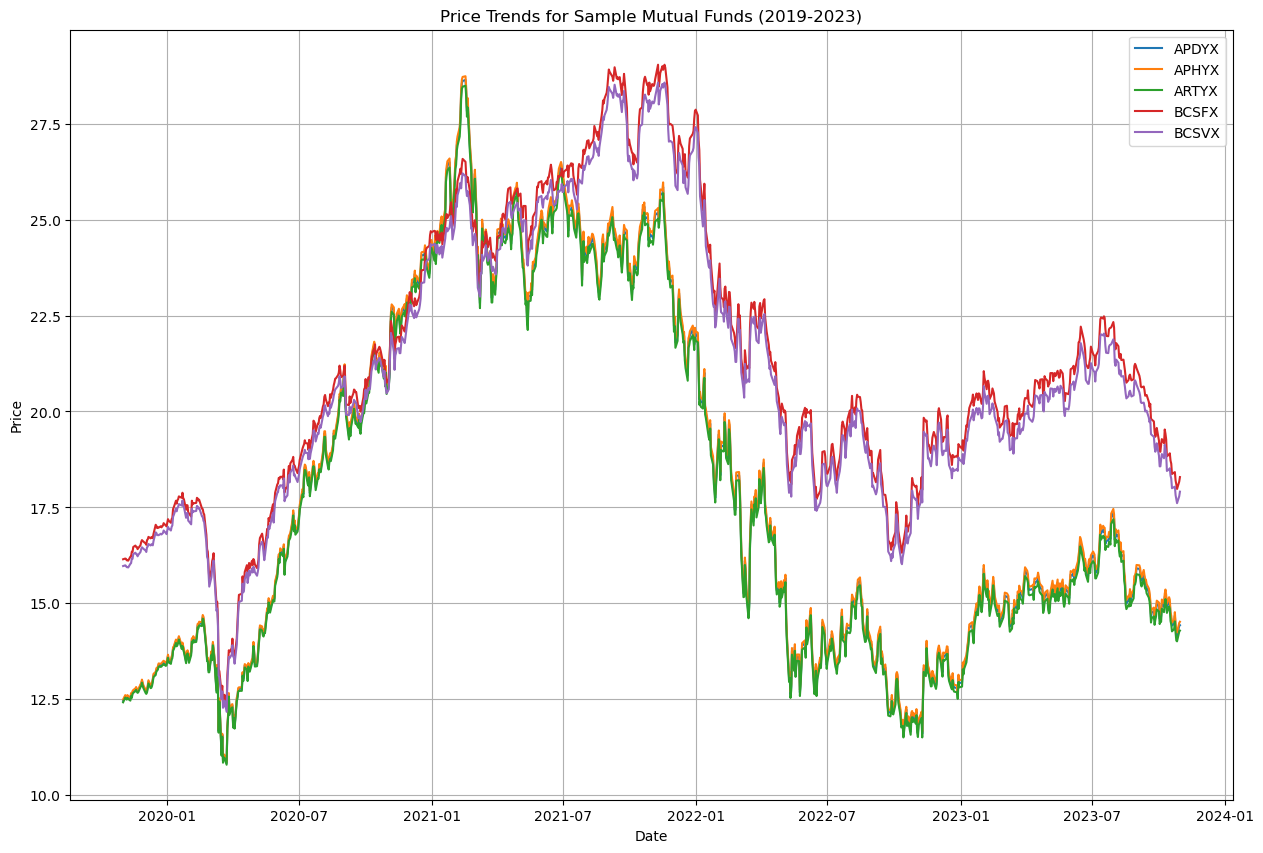

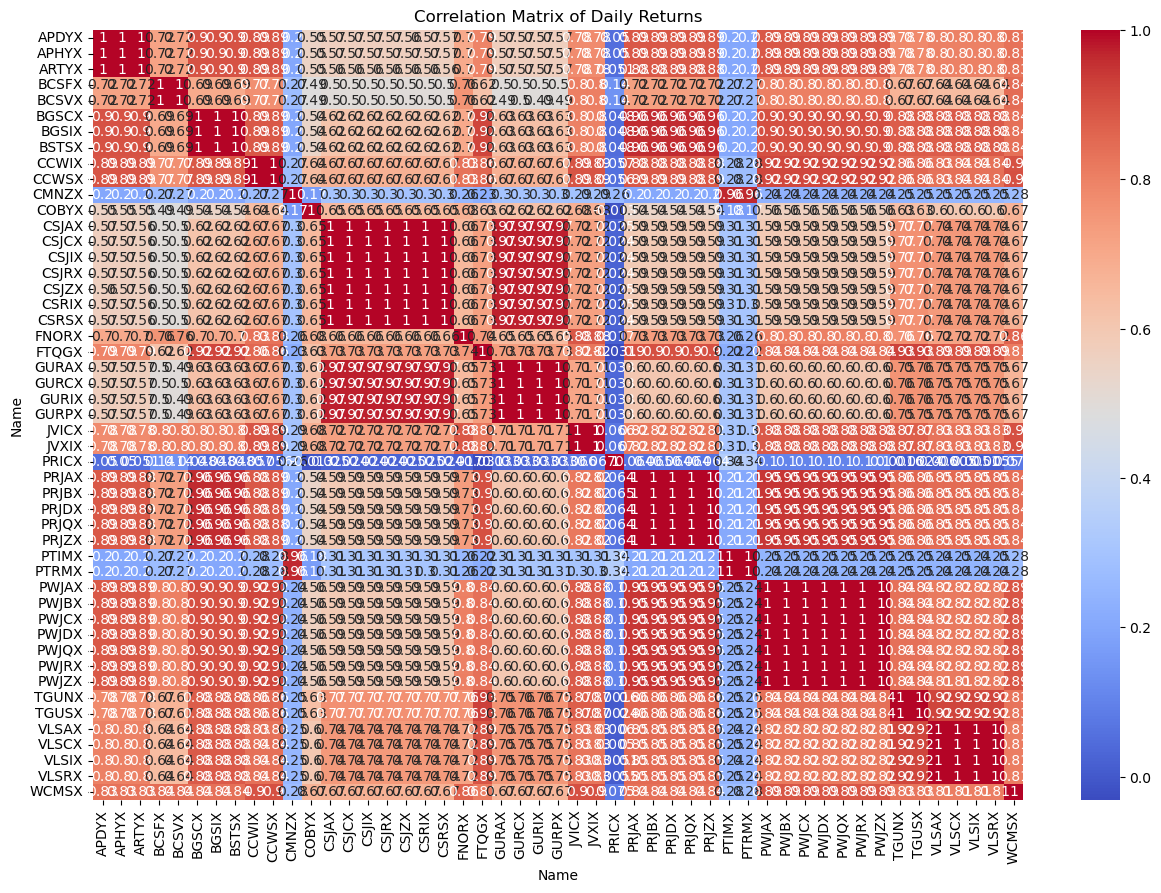

(                                date         Price  daily_return
 count                          49294  49294.000000  49245.000000
 mean   2021-10-31 23:38:31.729622272     30.448774      0.000273
 min              2019-11-01 00:00:00      7.400000     -0.177492
 25%              2020-10-30 00:00:00     19.523155     -0.006544
 50%              2021-10-30 12:00:00     25.889999      0.000440
 75%              2022-10-31 00:00:00     36.970001      0.007696
 max              2023-10-31 00:00:00     77.924721      0.103586
 std                              NaN     15.296363      0.015232,
 date             0
 Name             0
 Price            0
 daily_return    49
 dtype: int64)

In [19]:
# Descriptive statistics for the dataset
descriptive_stats = data.describe()

# Check for missing values
missing_values = data.isnull().sum()

# Histogram of daily returns for mutual funds
plt.figure(figsize=(10, 6))
sns.histplot(data['daily_return'], bins=50, kde=True)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

# Plotting the trends in prices over time for a few mutual funds
sample_funds = data['Name'].unique()[:5]  # Selecting a sample of 5 mutual funds for visualization
plt.figure(figsize=(15, 10))
for fund in sample_funds:
    fund_data = data[data['Name'] == fund]
    plt.plot(fund_data['date'], fund_data['Price'], label=fund)
plt.title('Price Trends for Sample Mutual Funds (2019-2023)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.show()

# Correlation matrix for the daily returns of mutual funds
daily_returns = data.pivot(index='date', columns='Name', values='daily_return')
correlation_matrix = daily_returns.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Daily Returns')
plt.show()

descriptive_stats, missing_values

In [20]:
# Splitting the data into two sets: 2019-2022 and 2023
data_training = data[data['date'] < datetime(2023, 1, 1)]
data_testing = data[data['date'] >= datetime(2023, 1, 1)]

# Calculating the average daily return (expected return) for each mutual fund for the training data
expected_returns = data_training.groupby('Name')['daily_return'].mean()

# Calculating the covariance matrix for the training data
covariance_matrix = data_training.pivot(index='date', columns='Name', values='daily_return').cov()

# Displaying the first few rows of expected returns and covariance matrix
expected_returns.head(), covariance_matrix.head()


(Name
 APDYX    0.000281
 APHYX    0.000286
 ARTYX    0.000274
 BCSFX    0.000304
 BCSVX    0.000295
 Name: daily_return, dtype: float64,
 Name      APDYX     APHYX     ARTYX     BCSFX     BCSVX     BGSCX     BGSIX  \
 Name                                                                          
 APDYX  0.000471  0.000471  0.000471  0.000212  0.000212  0.000397  0.000397   
 APHYX  0.000471  0.000471  0.000471  0.000212  0.000212  0.000397  0.000397   
 ARTYX  0.000471  0.000471  0.000471  0.000212  0.000212  0.000397  0.000397   
 BCSFX  0.000212  0.000212  0.000212  0.000185  0.000185  0.000193  0.000193   
 BCSVX  0.000212  0.000212  0.000212  0.000185  0.000186  0.000193  0.000193   
 
 Name      BSTSX     CCWIX     CCWSX  ...     PWJQX     PWJRX     PWJZX  \
 Name                                 ...                                 
 APDYX  0.000397  0.000281  0.000281  ...  0.000328  0.000327  0.000327   
 APHYX  0.000397  0.000281  0.000281  ...  0.000328  0.000327  0.000327   


In [21]:
# Number of assets in the portfolio
num_assets = len(expected_returns)

# Annualizing the expected returns and covariance matrix
annual_expected_returns = (1 + expected_returns).pow(252) - 1
annual_covariance_matrix = covariance_matrix * 252

# Function to calculate portfolio performance metrics
def portfolio_performance(weights, expected_returns, covariance_matrix):
    returns = np.dot(weights, expected_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    return returns, volatility

# Function to minimize (negative Sharpe Ratio)
def neg_sharpe_ratio(weights, expected_returns, covariance_matrix, risk_free_rate=0.02):
    p_returns, p_volatility = portfolio_performance(weights, expected_returns, covariance_matrix)
    return -(p_returns - risk_free_rate) / p_volatility

# Constraints (sum of weights is 1)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds for weights
bounds = tuple((0, 1) for asset in range(num_assets))

# Initial guess (equal distribution)
initial_guess = num_assets * [1. / num_assets]

# Optimization
optimal = minimize(neg_sharpe_ratio, initial_guess, args=(annual_expected_returns, annual_covariance_matrix), 
                   method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = optimal.x
optimal_weights, optimal.fun


(array([4.34875301e-17, 5.83795182e-16, 6.75883669e-17, 4.01653510e-16,
        3.77369510e-16, 8.79470044e-16, 0.00000000e+00, 7.59989868e-17,
        2.18095344e-16, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.74381229e-17, 1.44029571e-16, 0.00000000e+00, 4.19442177e-16,
        3.81586066e-16, 4.51899379e-16, 3.39246054e-16, 7.25263456e-01,
        2.19112431e-01, 3.53158850e-17, 0.00000000e+00, 1.87001063e-17,
        1.76863201e-16, 1.67666971e-16, 7.35431547e-17, 1.75084036e-16,
        0.00000000e+00, 7.41768639e-17, 1.50759350e-16, 1.43709892e-16,
        0.00000000e+00, 6.49840172e-17, 0.00000000e+00, 0.00000000e+00,
        1.32724828e-16, 1.44425559e-16, 0.00000000e+00, 5.51800759e-17,
        8.69646966e-17, 1.71852385e-16, 1.22791857e-17, 0.00000000e+00,
        3.95540259e-16, 2.23190265e-17, 0.00000000e+00, 5.56241135e-02,
        0.00000000e+00]),
 -0.49421008405092626)

In [22]:
# Extracting the names of the funds corresponding to the significant weights
significant_weights = optimal_weights[optimal_weights > 0.01]  # threshold for significant weights
significant_fund_names = expected_returns.index[optimal_weights > 0.01]

# Creating a dictionary of fund names with their corresponding significant weights
significant_weights_dict = {fund: weight for fund, weight in zip(significant_fund_names, significant_weights)}

significant_weights_dict


{'FNORX': 0.7252634556788058,
 'FTQGX': 0.21911243086561122,
 'VLSRX': 0.0556241134555816}

In [23]:
# Applying the optimal weights to the 2023 data
# First, pivot the 2023 data to have dates as index and mutual fund names as columns
data_testing_pivoted = data_testing.pivot(index='date', columns='Name', values='daily_return')

# Calculate the daily portfolio return for 2023
data_testing_pivoted['portfolio_return'] = data_testing_pivoted.dot(optimal_weights)

# Calculate the cumulative return for 2023
cumulative_return_2023 = (1 + data_testing_pivoted['portfolio_return']).cumprod() - 1

# Last cumulative return value is the total return for the year 2023
total_return_2023 = cumulative_return_2023.iloc[-1]

# Expected annual return based on the model
expected_annual_return = np.dot(optimal_weights, annual_expected_returns)

total_return_2023, expected_annual_return


(0.05548304407635052, 0.13740135509880502)

In [24]:
def generate_simulated_data(data, year=2024, days_per_year=252):

    # Calculating mean and standard deviation for each mutual fund
    fund_stats = data.groupby('Name')['daily_return'].agg(['mean', 'std'])

    # Initializing random number generator
    rng = default_rng()

    # Generating simulated daily returns for each mutual fund
    simulated_data = []
    for fund, stats in fund_stats.iterrows():
        daily_returns = rng.normal(loc=stats['mean'], scale=stats['std'], size=days_per_year)
        dates = pd.date_range(start=f'{year}-01-01', periods=days_per_year, freq='B')
        for date, return_ in zip(dates, daily_returns):
            simulated_data.append({'date': date, 'Name': fund, 'daily_return': return_})

    # Creating a DataFrame from the simulated data
    simulated_df = pd.DataFrame(simulated_data)

    return simulated_df

# Generate simulated dataset for 2024
simulated_data_2024 = generate_simulated_data(data)
simulated_data_2024.head()


,date,Name,daily_return
0,2024-01-01,APDYX,-0.014304
1,2024-01-02,APDYX,0.014097
2,2024-01-03,APDYX,0.012916
3,2024-01-04,APDYX,-0.011882
4,2024-01-05,APDYX,-0.022193


In [25]:
# Applying the optimal weights to the simulated 2024 data

# First, pivot the 2024 data to have dates as index and mutual fund names as columns
simulated_data_2024_pivoted = simulated_data_2024.pivot(index='date', columns='Name', values='daily_return')

# Fill any missing values (due to non-trading days) with zeros
simulated_data_2024_pivoted.fillna(0, inplace=True)

# Calculate the daily portfolio return for 2024 using the optimal weights obtained earlier
simulated_data_2024_pivoted['portfolio_return'] = simulated_data_2024_pivoted.dot(optimal_weights)

# Calculate the cumulative return for 2024
cumulative_return_2024 = (1 + simulated_data_2024_pivoted['portfolio_return']).cumprod() - 1

# Last cumulative return value is the total return for the year 2024
total_return_2024 = cumulative_return_2024.iloc[-1]

# Calculate volatility and Sharpe Ratio for the portfolio in 2024
portfolio_volatility_2024 = simulated_data_2024_pivoted['portfolio_return'].std() * np.sqrt(252)
sharpe_ratio_2024 = (total_return_2024 - 0.02) / portfolio_volatility_2024  # Assuming a risk-free rate of 2%

total_return_2024, portfolio_volatility_2024, sharpe_ratio_2024



(0.04892156874701281, 0.189005951973051, 0.15301935439121267)